In [38]:
import pandas as pd
import pydicom as dicom
from PIL import Image
import numpy as np
import os
import cv2
import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt
import re

In [39]:
### USEFUL FINCTIONS 

def get_maximum_stenosis_score_category(section_stenosis_string):
    """
    Returns the max stenois score category
    
    Args:
        - section_stenosis_string(str): NORMAL_<25%_NORMAL
    
    Returns:
        - max_stenosis_score(str): <25%
    """
    categories = section_stenosis_string.split('_')
    numbers = [[int(i) for i in re.findall(r'\d+', x)] for x in categories]
    max_elements_of_sublists = [max(x or [0]) for x in numbers]
    max_stenosis_category = categories[max_elements_of_sublists.index(max(max_elements_of_sublists))]
    
    return max_stenosis_category

def remove_thrash_categories(df):
    """
    Merge rare stenosis scores into the broader ones.
    """
    right_categies_names = {
     '<25%': ['<35%'], #'25%'],
     '25-50%': ['-25-50%', '<25-50%'],
     '50%': ['*50%'], #'>50%'],
     '50-70%': ['50-75%'],
     '70-90%': ['>70%', '>75%'],
     '90-100%': ['>90%', '90%']
    }
    for right_category in right_categies_names:
        df.replace(right_categies_names[right_category], right_category, inplace=True)
    return df

### Read reports

In [40]:
lad = pd.read_excel('lad_reports.xlsx')
rca = pd.read_excel('rca_reports.xlsx')
lcx = pd.read_excel('lcx_reports.xlsx')



In [41]:
assert len(np.intersect1d(lad['PATIENT_ID'].values, rca['PATIENT_ID'].values)) == lad.shape[0] 
assert len(np.intersect1d(lad['PATIENT_ID'].values, lcx['PATIENT_ID'].values)) == lad.shape[0] 

In [42]:
lad.shape, rca.shape, lcx.shape

((744, 8), (744, 7), (744, 10))

In [43]:
lad.columns, rca.columns, lcx.columns

(Index(['PATIENT_ID', 'PROXIMAL', 'MID', 'DISTAL', 'D-1', 'D-2', 'D-3', 'D-4'], dtype='object'),
 Index(['PATIENT_ID', 'REPORT_ID', 'PROXIMAL', 'DISTAL', 'MID', 'PDA', 'PLV'], dtype='object'),
 Index(['PATIENT_ID', 'REPORT_ID', 'PROXIMAL', 'DISTAL', 'OM', 'OM1', 'OM2',
        'OM3', 'PDA', 'PLV'],
       dtype='object'))

### Merge all sections to one table

In [44]:
# Merge proximal mid distal
lad['LAD'] = lad['PROXIMAL'] +'_'+ lad['MID'] +'_'+ lad['DISTAL']
rca['RCA'] = rca['PROXIMAL'] +'_'+ rca['MID'] +'_'+ rca['DISTAL']
lcx['LCX'] = lcx['PROXIMAL'] +'_'+ lcx['DISTAL']

# Del redundant columns
for df in [lad, rca, lcx]:
    del df['PROXIMAL']
    del df['DISTAL']
del lad['MID']
del rca['MID']

# Merge tables, removing redundant columns
lad_rca = pd.merge(lad, rca, on='PATIENT_ID')
lad_rca_lcx = pd.merge(lad_rca, lcx, on='PATIENT_ID')  # FULL DATAFRAME FOR ALL BRANCHES!
lad_rca_lcx.drop(['D-4', 'PDA_x', 'PDA_y', 'PLV_x', 'PLV_y', 'REPORT_ID_y'], axis=1, inplace=True)
lad_rca_lcx.rename(columns={'REPORT_ID_x': 'REPORT_ID'}, inplace=True)
new_order = [0, 5, 4, 1, 2, 3, 6, 7, 8, 9, 10, 11]
lad_rca_lcx = lad_rca_lcx[lad_rca_lcx.columns[new_order]]

lad_rca_lcx.columns

Index(['PATIENT_ID', 'REPORT_ID', 'LAD', 'D-1', 'D-2', 'D-3', 'RCA', 'OM',
       'OM1', 'OM2', 'OM3', 'LCX'],
      dtype='object')

In [45]:
# Convert proximalMidDistal string to stenosis category
for branch in ['LAD', 'RCA', 'LCX']:
    lad_rca_lcx[branch] = lad_rca_lcx[branch].apply(get_maximum_stenosis_score_category)

remove_thrash_categories(lad_rca_lcx).head()

,PATIENT_ID,REPORT_ID,LAD,D-1,D-2,D-3,RCA,OM,OM1,OM2,OM3,LCX
0,CTCAHER21101967,CTCAHER21101967,<25%,NORMAL,-,-,NORMAL,-,NORMAL,-,-,NORMAL
1,CTCAGRH27071943,CTCAGRH27071943,NORMAL,NORMAL,-,-,-,-,NORMAL,NORMAL,-,NORMAL
2,CTCADRG22021959,CTCADRG22021959,<25%,<25%,<25%,NORMAL,<25%,-,NORMAL,-,-,NORMAL
3,CTCAXUZ07071955,CTCAXUZ07071955,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,-,NORMAL,NORMAL,-,NORMAL
4,CTCAQUD02121959,CTCAQUD02121959,70%,NORMAL,NORMAL,-,70%,-,NORMAL,NORMAL,NORMAL,NORMAL


In [46]:
lad_rca_lcx.head()

,PATIENT_ID,REPORT_ID,LAD,D-1,D-2,D-3,RCA,OM,OM1,OM2,OM3,LCX
0,CTCAHER21101967,CTCAHER21101967,<25%,NORMAL,-,-,NORMAL,-,NORMAL,-,-,NORMAL
1,CTCAGRH27071943,CTCAGRH27071943,NORMAL,NORMAL,-,-,-,-,NORMAL,NORMAL,-,NORMAL
2,CTCADRG22021959,CTCADRG22021959,<25%,<25%,<25%,NORMAL,<25%,-,NORMAL,-,-,NORMAL
3,CTCAXUZ07071955,CTCAXUZ07071955,NORMAL,NORMAL,NORMAL,NORMAL,NORMAL,-,NORMAL,NORMAL,-,NORMAL
4,CTCAQUD02121959,CTCAQUD02121959,70%,NORMAL,NORMAL,-,70%,-,NORMAL,NORMAL,NORMAL,NORMAL


In [47]:
lad_rca_lcx.rename(columns={"OM1": "OM-1", "OM2": "OM-2", "OM3": "OM-3"}, inplace=True)

In [48]:
lad_rca_lcx.to_excel('lad_rca_lcx.xlsx')

In [26]:
stenosis_statistics = {}
for branch in lad_rca_lcx:
    if branch in ['PATIENT_ID', 'REPORT_ID']:
        continue
    cur_dict = pd.value_counts(lad_rca_lcx[branch]).to_dict()
    for key in cur_dict:
        if key in stenosis_statistics.keys():
            stenosis_statistics[key] += cur_dict[key]
        else:
            stenosis_statistics[key] = cur_dict[key]
    del stenosis_statistics['-']



ValueError: could not broadcast input array from shape (744,2) into shape (744)

In [65]:
normal_num = stenosis_statistics.pop('NORMAL')


{'25%': 194,
 '25-50%': 352,
 '50%': 59,
 '50-70%': 161,
 '70%': 20,
 '70-90%': 68,
 '90-100%': 10,
 '<25%': 469,
 '>50%': 6,
 'NORMAL': 3276}

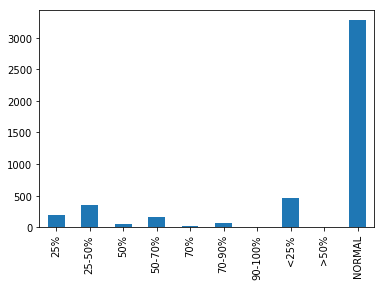

In [66]:
pd.Series(stenosis_statistics).plot(kind='bar')

### Questions

1. Wether 25% and <25% are the same or 25% is the same as 25-50% of stenosis score?
2. Wether 50% and 50-70% are the same or 50% means 25-50% stenosis score estimation?
3. Wether >50% are the same as 50-70% stenosis score estimation?
4. Wether 70% is the same as 50-70% or it is the same as >70% i.e. 70-90%?

# OLD VERSION BELOW

In [ ]:
for branch in ['LAD', 'RCA', 'LCX', 'D-1', 'D-2', 'OM', 'OM1', 'OM2', 'OM3']:
    s = lad_rca_lcx[branch].values
    d = {'0':1, '25':2, '25-50':3, '50':4,'50-70':5, '70':6}
    temp = [ ''.join(re.sub('[>,%<]', ' ', el)) for el in s]
    temp = [re.findall(r'\d+',el) for el in temp]
    print(temp)
    break
#     if branch in ['LAD', 'RCA', 'LCX']:
#         temp = [' '.join(re.sub('[>,%<]', ' ', el).split('_')).replace('NORMAL', '0').split() for el in s]
#         temp = [list(d.keys())[list(d.values()).index(el)] for el in temp]
#         print(temp)
#         temp = [max([d[i] for i in t ]) for t in temp]
#     else:
#         temp = ' '.join(re.sub('[>,%<]', ' ', el))
#         s = [list(d.keys())[list(d.values()).index(el)] for el in temp]
#     print(s)
#     lad_rca_lcx[branch] = s

### Merge all tables

In [ ]:
result = pd.merge(lad, rca, on='PATIENT_ID', suffixes=['_LAD', '_RCA'])
result.drop(['PDA', 'PLV','D-4','D-3'], axis=1, inplace=True)
result = pd.merge(result, lcx, on='REPORT_ID')

result.drop(['PDA','PLV', 'OM'], axis=1)

In [ ]:
result.head()

In [ ]:
lad.head()

In [ ]:
rca.head()

In [ ]:
lcx.head()

# 1. Stage statistics

### RCA

In [ ]:
pd.value_counts(rca['PROXIMAL']).plot(kind='bar')

In [ ]:
pd.value_counts(rca['MID']).plot(kind='bar')

In [ ]:
pd.value_counts(rca['DISTAL']).plot(kind='bar')

### LCX

In [ ]:
pd.value_counts(lcx['OM']).plot(kind='bar')

### LAD

In [ ]:
pd.value_counts(lad['D-1']).plot(kind='bar')


# 2. Patient statistics

# 3. Balance positive VS negative

# 4. Statistics per branches